<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/SkimLit-Chrome-Extension/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Skimlit
The propose of this project is to built an NLP model to make reading medical abstract easier.

The paper we are replicating (the source of dataset that we'll be using) is available here: https://arxiv.org/pdf/1710.06071


In [11]:
!nvidia-smi -L


/bin/bash: line 1: nvidia-smi: command not found


## Get the data
PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts https://github.com/Franck-Dernoncourt/pubmed-rct

In [12]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [13]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [14]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os
filename=[data_dir+filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [15]:
# Preprocess data
def get_lines(filename):
  with open(filename) as file:
    return file.readlines()

In [16]:
train_lines=get_lines(filename[0])
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [17]:
def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename)
  abstract_line=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_line=""

    elif line.isspace():
      abstract_line_split=abstract_line.splitlines()
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_line+=line
  return abstract_samples

In [18]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [19]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [20]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


# Distribution of labels in the training data


In [21]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


It seems like the abstract talks mostly about Methods and Results and less about Objective

<Axes: ylabel='Frequency'>

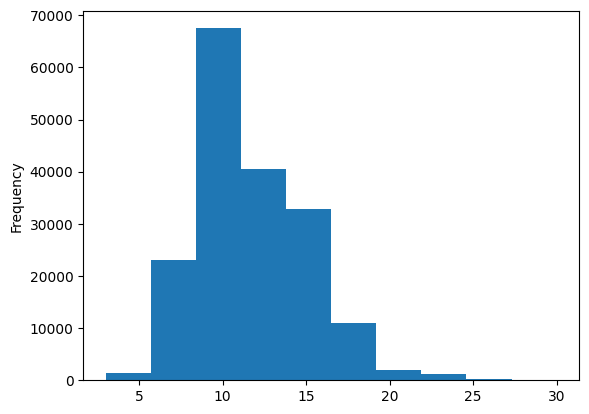

In [22]:
train_df.total_lines.plot.hist()

From this Histogram, it seems like most of the abstract has the length of 7-18

# Converting the abstract lines into list

In [23]:
train_sentences=train_df.text.to_list()
test_sentences=test_df.text.to_list()
validation_sentences=val_df.text.to_list()
validation_sentences[:10]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
 'sixty-five patients were randomized .',
 'fifty-nine patients started treatment ( @ receiving voriconazole and @ receiving plac

# Make numeric labels
Lets make one-hot and label encoded labels. TF CategoricalCrossentropy loss function likes to have one hot encoded labels

In [24]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot=one_hot_encoder.fit_transform(val_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot[:10],train_labels_one_hot[:10],test_labels_one_hot[:10]


(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]))

# label encode labels

In [25]:
# Extract target columns and encode into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels=label_encoder.fit_transform(train_df.target.to_numpy())
test_labels=label_encoder.fit_transform(test_df.target.to_numpy())
validation_labels=label_encoder.fit_transform(val_df.target.to_numpy())
train_labels[:10],test_labels[:10],validation_labels[:10]

(array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4]),
 array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0]),
 array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1]))

In [26]:
# Get the names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [27]:
train_labels

array([3, 2, 2, ..., 4, 1, 1])

# Model 0: Baseline
TF-IDF Multinomial Naive Bayes Classifier

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([("tf-idf",TfidfVectorizer()),
                  ("clf",MultinomialNB()),
                  ])
# Fit the pipeline
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
# Evaluate baseline model
model_0.score(X=validation_sentences,y=validation_labels)

0.7218323844829869

In [30]:
# make prediction
baseline_preds=model_0.predict(validation_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [31]:
validation_labels[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [32]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py


--2025-05-27 21:06:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-27 21:06:36 (88.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [33]:
from helper_functions import calculate_results


In [34]:
# calculate baseline results
baseline_results=calculate_results(y_true=validation_labels,y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Model 1: simple Dense Model

In [35]:
# create tensorboard callback
from helper_functions import create_tensorboard_callback
SAVE_DIR="model_logs"


 Lets create a text vectorization and embedding layers. The vectorization layer convert the text into numbers and the embedding layer will capture the relationship between those numbers

In [36]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

In [37]:
max_vocab_length=sum([len(i.split()) for i in train_sentences])
max_vocab_length

4741942

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

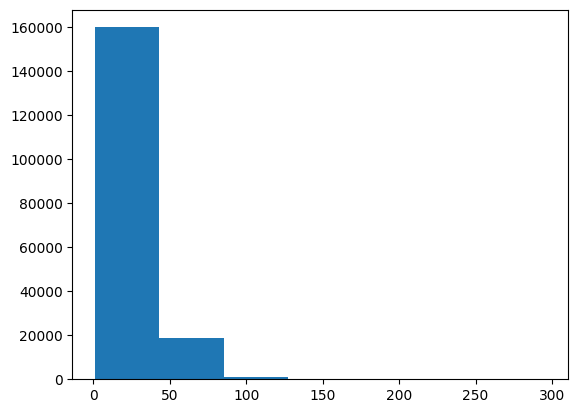

In [38]:
# Lets check the distribution of the sentence length
import matplotlib.pyplot as plt
sentence_lengths=[len(i.split()) for i in train_sentences]
plt.hist(sentence_lengths,bins=7)

In [39]:
# How long of a sentence covers 95% of the lengths?
import numpy as np
output_sen_len=int(np.percentile(sentence_lengths,95))
output_sen_len

55

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.



In [40]:
import tensorflow as tf

max_length=55
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=68000,
                                                  output_sequence_length=max_length)


let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.



In [41]:
text_vectorizer.adapt(train_sentences)

In [42]:
# Testing our text vectorizer
import random
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
the study was planned as a multicenter , pragmatic ( with centers different in size and experience ) , randomized , single-blinded ( with blinding of patients only ) , parallel group trial .        

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   2,   17,   10, 1362,   25,    8,  502, 2133,    7,  897,  197,
           5,  375,    3,  794,   29, 2795,    7, 4605,    4,   12,  192,
         878,   13,   32,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [43]:
# how many words are there in the vocabolary
rct_20k_vocab=text_vectorizer.get_vocabulary()
len(rct_20k_vocab)

64841

In [44]:
# Get the configuration of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [45]:
len(rct_20k_vocab)

64841

In [46]:
embeddings=tf.keras.layers.Embedding(input_dim=len(rct_20k_vocab), # length of vocabolary
                                     output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                                     mask_zero=True, # Use masking to handle variable sequences lengths
                                     name="embedding")


In [47]:
# Testing our text vectorizer
import random
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
print(text_vectorizer([random_sentence]))

# testing our embedding
print("########## After embeddings #########")
after_embeddings=embeddings(text_vectorizer([random_sentence]))
after_embeddings,after_embeddings.shape

Original text:
the primary variable was the clinical cure ( absence of bulbar conjunctival injection and discharge ) on d@ in the worse eye for patients with positive cultures on d@ .        

Vectorized version:
tf.Tensor(
[[    2    56  1251    10     2    47  2002  1461     4 10849  3787   390
      3   696    18   187     5     2  1327   672    11    12     7   280
   4439    18   187     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)
########## After embeddings #########


(<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[ 0.01492904,  0.02530987,  0.02168996, ...,  0.03537469,
           0.01835913,  0.01874207],
         [ 0.00347626, -0.03839325,  0.00418416, ..., -0.00519992,
           0.02076203, -0.0151508 ],
         [-0.04974523, -0.00954373,  0.0361661 , ..., -0.04397421,
           0.01931772,  0.01016856],
         ...,
         [-0.02614144, -0.02786505, -0.00119736, ..., -0.04532752,
           0.03081911,  0.01098212],
         [-0.02614144, -0.02786505, -0.00119736, ..., -0.04532752,
           0.03081911,  0.01098212],
         [-0.02614144, -0.02786505, -0.00119736, ..., -0.04532752,
           0.03081911,  0.01098212]]], dtype=float32)>,
 TensorShape([1, 55, 128]))

To create a batched PrefetchDataset we can use the methods betch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow Tensowflow to determine the optimal amount of compute to use to prepare datasets

In [48]:
# Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
validation_dataset=tf.data.Dataset.from_tensor_slices((validation_sentences,validation_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [49]:
# Take the tensor slices and turn them in to prefetch Batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Model 1: Conv1D with token embeddings

Input(text)-> Tokenize-> Embeddings -> Layers -> Output (label Probalility)

In [50]:
# Build a model with Functional API
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
x=layers.Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1_dense")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary(
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Fit the model
model_1_history=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)), # Only fit 10% of the batches for the faster training time
                            epochs=5,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(validation_dataset))
                            )

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 68s 118ms/step - accuracy: 0.5251 - loss: 1.1599 - val_accuracy: 0.7397 - val_loss: 0.6919
Epoch 2/5
  2/562 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - accuracy: 0.7812 - loss: 0.8000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


562/562 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - accuracy: 0.7452 - loss: 0.6852 - val_accuracy: 0.7686 - val_loss: 0.6458
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 60s 106ms/step - accuracy: 0.7699 - loss: 0.6228 - val_accuracy: 0.7864 - val_loss: 0.5988
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - accuracy: 0.7865 - loss: 0.5968 - val_accuracy: 0.7930 - val_loss: 0.5775
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 66s 118ms/step - accuracy: 0.7896 - loss: 0.5894 - val_accuracy: 0.8006 - val_loss: 0.5609


In [52]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8000 - loss: 0.5582


[0.5609381794929504, 0.8006090521812439]

In [53]:
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


array([[0.7816254 , 0.5254482 , 0.21428996, 0.5446934 , 0.23894879],
       [0.75986576, 0.7010324 , 0.14562246, 0.53402305, 0.24857654],
       [0.9061572 , 0.20504028, 0.07371273, 0.97582686, 0.00275485],
       ...,
       [0.01925367, 0.20030452, 0.64830154, 0.01356505, 0.9974079 ],
       [0.23835117, 0.52119476, 0.36999935, 0.19140679, 0.635162  ],
       [0.63706845, 0.9033534 , 0.48308825, 0.1333134 , 0.18933547]],
      dtype=float32)

In [54]:
model_1_results=calculate_results(y_true=validation_labels,y_pred=tf.argmax(model_1_pred_probs,axis=1))
model_1_results

{'accuracy': 80.06090295246922,
 'precision': 0.8007888328916376,
 'recall': 0.8006090295246922,
 'f1': 0.7972616810659384}

# Model 2: Transfer Learning
The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)


There is lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

In [55]:
# Building and fitting an NLP feature extraction model from TF Hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Wrap USE inside a custom Keras Layer
class USEEmbedding(tf.keras.layers.Layer):
    def __init__(self, trainable=False, **kwargs):
        super(USEEmbedding, self).__init__(trainable=trainable, **kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Keras Input (1D: batch of strings)
input_text = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")

# Embed using our wrapped USE Layer
embedding = USEEmbedding()(input_text)

# Add classification layers
x = layers.Dense(128, activation="relu")(embedding)
output = layers.Dense(num_classes, activation="sigmoid")(x)

# Build model
model_2 = Model(inputs=input_text, outputs=output)
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Show model summary
model_2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding (USEEmbedding)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# model_2.fit(train_dataset,
#             steps_per_epoch=int(0.1*len(train_dataset)),
#             epochs=5,
#             validation_data=valid_dataset,
#             validation_steps=int(0.1*len(valid_dataset))
#             )

In [57]:
# # Evaluate
# model_2_preds=model_2.predict(valid_dataset)
# model_2_preds

In [58]:
# model_2_results=calculate_results(validation_labels,tf.argmax(model_2_preds,axis=1))
# model_2_results

# Model 3: Conv1D with character embeddings
The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens. Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

In [59]:
# Make function to split senntences into characters
def split_sentences(text):
  return " ".join(list(text))

In [60]:
# Testing functioon
split_sentences(random_sentence)

't h e   p r i m a r y   v a r i a b l e   w a s   t h e   c l i n i c a l   c u r e   (   a b s e n c e   o f   b u l b a r   c o n j u n c t i v a l   i n j e c t i o n   a n d   d i s c h a r g e   )   o n   d @   i n   t h e   w o r s e   e y e   f o r   p a t i e n t s   w i t h   p o s i t i v e   c u l t u r e s   o n   d @   .'

In [61]:
# Lets  create character level dataset by splitting our dataset into characters
train_chars=[split_sentences(s) for s in train_sentences]
val_chars=[split_sentences(s) for s in validation_sentences]
test_chars=[split_sentences(s) for s in test_sentences]
test_chars[0]

't h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .'

In [62]:
# lets check the average character length
char_length=[len(s) for s in train_sentences]
mean_chars=np.mean(char_length)
mean_chars

np.float64(149.3662574983337)

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

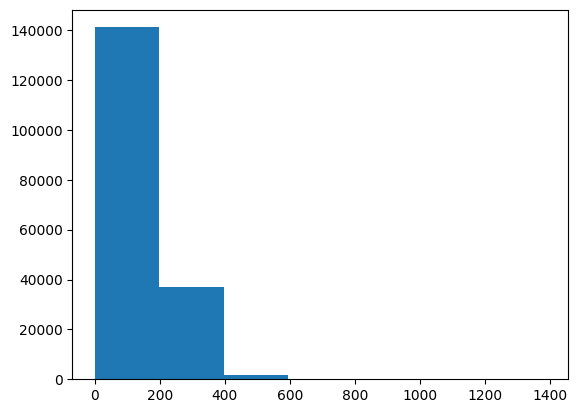

In [63]:
plt.hist(char_length,bins=7
         )

In [64]:
# Lets find the 95% percentile of our character length
output_char_length=int(np.percentile(char_length,95))
output_char_length

290

we'll set the max_tokens ( the total number of different character in our sentences) to 28, in other words, 26 letters of the alphabet + space +OOV (Out of vocabolary or unknown) tokens.


In [65]:
# get all keyboard character for character level embeddings
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
# create  char level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet)+2 # this means number of characters in alphabet + space + OOV token
char_vectorizer=tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_char_length,
                                  standardize="lower_and_strip_punctuation",
                                  name="char_vectorizer")
# adapt char vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [67]:
# lets check the character vocabolary characterstics
char_vocab= char_vectorizer.get_vocabulary()
print(f"Number of character in vocabolary {len(char_vocab)}")
print(f" 5 most common characters { char_vocab[:5]}")
print(f" 5 least common characters { char_vocab[:-5]}")

Number of character in vocabolary 28
 5 most common characters ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
 5 least common characters ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i'), np.str_('a'), np.str_('n'), np.str_('o'), np.str_('r'), np.str_('s'), np.str_('d'), np.str_('c'), np.str_('l'), np.str_('h'), np.str_('p'), np.str_('m'), np.str_('u'), np.str_('f'), np.str_('g'), np.str_('y'), np.str_('w'), np.str_('v'), np.str_('b')]


In [68]:
# Lets test out char vectorizer
random_chars=random.choice(train_chars)
print(f"Random sentence : {random_chars}")
print(f"vectorized sentence : {char_vectorizer([random_chars])}")
print(f"length: {len(char_vectorizer([random_chars])[0])}")

Random sentence : a   p e r i p a n c r e a t i c   v a s c u l a r   r e c o n s t r u c t i o n   c a n   r e v e a l   t h e   v a s c u l a r   a n a t o m y   ,   v a r i a t i o n s   o f   p e r i p a n c r e a t i c   v a s c u l a r   ,   a n d   t u m o r - i n d u c e d   v a s c u l a r   c h a n g e s   ;   t h e   a p p l i c a t i o n   o f   t h e   s i m u l a t i o n   s u r g e r y   p l a t f o r m   c o u l d   r e d u c e   s u r g i c a l   t r a u m a   a n d   d e c r e a s e   o p e r a t i v e   t i m e   .
vectorized sentence : [[ 5 14  2  8  4 14  5  6 11  8  2  5  3  4 11 21  5  9 11 16 12  5  8  8
   2 11  7  6  9  3  8 16 11  3  4  7  6 11  5  6  8  2 21  2  5 12  3 13
   2 21  5  9 11 16 12  5  8  5  6  5  3  7 15 19 21  5  8  4  5  3  4  7
   6  9  7 17 14  2  8  4 14  5  6 11  8  2  5  3  4 11 21  5  9 11 16 12
   5  8  5  6 10  3 16 15  7  8  4  6 10 16 11  2 10 21  5  9 11 16 12  5
   8 11 13  5  6 18  2  9  3 13  2  5 14 14 12  4 11  5  3  4  7  6 

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for [Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251), the output dimension of the character embedding (output_dim) will be 25.

In [69]:
# create a character embedding layer
print(random_chars)
char_embedding=layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                output_dim=25,
                                mask_zero=False,
                                name="char_embedding")

char_embedding_output=char_embedding(char_vectorizer([random_chars]))
print(char_embedding_output)

a   p e r i p a n c r e a t i c   v a s c u l a r   r e c o n s t r u c t i o n   c a n   r e v e a l   t h e   v a s c u l a r   a n a t o m y   ,   v a r i a t i o n s   o f   p e r i p a n c r e a t i c   v a s c u l a r   ,   a n d   t u m o r - i n d u c e d   v a s c u l a r   c h a n g e s   ;   t h e   a p p l i c a t i o n   o f   t h e   s i m u l a t i o n   s u r g e r y   p l a t f o r m   c o u l d   r e d u c e   s u r g i c a l   t r a u m a   a n d   d e c r e a s e   o p e r a t i v e   t i m e   .
tf.Tensor(
[[[ 0.03144879 -0.04768426 -0.01228505 ... -0.00252132  0.02809175
   -0.01027115]
  [ 0.02054378  0.04792613 -0.0427641  ... -0.03164767  0.00421432
    0.00787612]
  [ 0.03374388 -0.03808713  0.01080507 ... -0.01620847 -0.00734388
   -0.00747041]
  ...
  [-0.02325705  0.00279845  0.00853644 ... -0.04585192  0.03234652
   -0.02300501]
  [-0.02325705  0.00279845  0.00853644 ... -0.04585192  0.03234652
   -0.02300501]
  [-0.02325705  0.00279845  0.00853644 ... -0.

Lets make our model

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [70]:
inputs=layers.Input(shape=(1,),dtype="string")
char_vectors=char_vectorizer(inputs)
embedding=char_embedding(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same", activation="relu")(embedding)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )

In [71]:
model_3.summary()

Model: "model_3_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embedding (Embedding)      │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

Before fitting our model, lets create a char-level batched PrefetchedDataset

In [72]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,validation_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Just line our token-level sequence model, to save time with our experiments, we'll fit our model in 10% of batches

In [74]:
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=5,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))


Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.4360 - loss: 1.3917 - val_accuracy: 0.5805 - val_loss: 1.0643
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.5823 - loss: 1.0537 - val_accuracy: 0.6220 - val_loss: 0.9588
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6259 - loss: 0.9525 - val_accuracy: 0.6632 - val_loss: 0.8717
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6574 - loss: 0.8942 - val_accuracy: 0.6752 - val_loss: 0.8390
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6705 - loss: 0.8598 - val_accuracy: 0.6832 - val_loss: 0.8184


In [75]:
# evaluate on whole validation dataset
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6785 - loss: 0.8316


[0.8341326713562012, 0.6774791479110718]

In [76]:
# Make predictions
model_3_pred=model_3.predict(val_char_dataset)
model_3_pred

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


array([[0.19840702, 0.58940476, 0.09225312, 0.10132433, 0.01861068],
       [0.24499084, 0.551572  , 0.02066758, 0.15223844, 0.0305311 ],
       [0.12025159, 0.19943231, 0.30574754, 0.32619816, 0.04837038],
       ...,
       [0.01006243, 0.01778722, 0.09435444, 0.02062404, 0.8571719 ],
       [0.01370417, 0.05878102, 0.50876456, 0.00914475, 0.40960547],
       [0.2887496 , 0.5338155 , 0.09336692, 0.0718392 , 0.0122288 ]],
      dtype=float32)

In [77]:
# convert predictions to classes
model_3_pred_classes=tf.argmax(model_3_pred,axis=1)
model_3_pred_classes

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [78]:
model_3_results=calculate_results(validation_labels,model_3_pred_classes)
model_3_results

{'accuracy': 67.74791473586654,
 'precision': 0.6792089062100445,
 'recall': 0.6774791473586654,
 'f1': 0.6709018291445005}

# Model 4: combining pretrained token embeddings and char embeddings (hybrid embedding)

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Combine (using layers.Concatenate) the outputs of 1 and 2
Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text  # Required for USE

# Step 1: Wrap the USE model in a Keras-compatible layer
class USEWrapper(layers.Layer):
    def __init__(self, **kwargs):
        super(USEWrapper, self).__init__(**kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Step 2: Token-level input model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embedding = USEWrapper(name="use_layer")(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embedded = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedded)
char_model = keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Step 4: Concatenate token and char outputs
token_char_concat = layers.Concatenate(name="concatenated")(
    [token_model.output, char_model.output]
)

# Step 5: Output layers
x = layers.Dropout(0.5)(token_char_concat)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(5, activation="softmax")(x)  # Adjust number of classes

# Step 6: Full model
model_4 = keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_hybrid"
)

# Compile model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Optional: Print model summary
model_4.summary()


Model: "model_4_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer           │ (None, 512)       │          0 │ token_input[0][0] │
│ (USEWrapper)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 290, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ use_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50)        │     10,200 │ char_embedding[1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated        │ (None, 178)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178)       │          0 │ concatenated[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │     35,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │      1,005 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,419 (446.95 KB)

 Trainable params: 114,419 (446.95 KB)

 Non-trainable params: 0 (0.00 B)

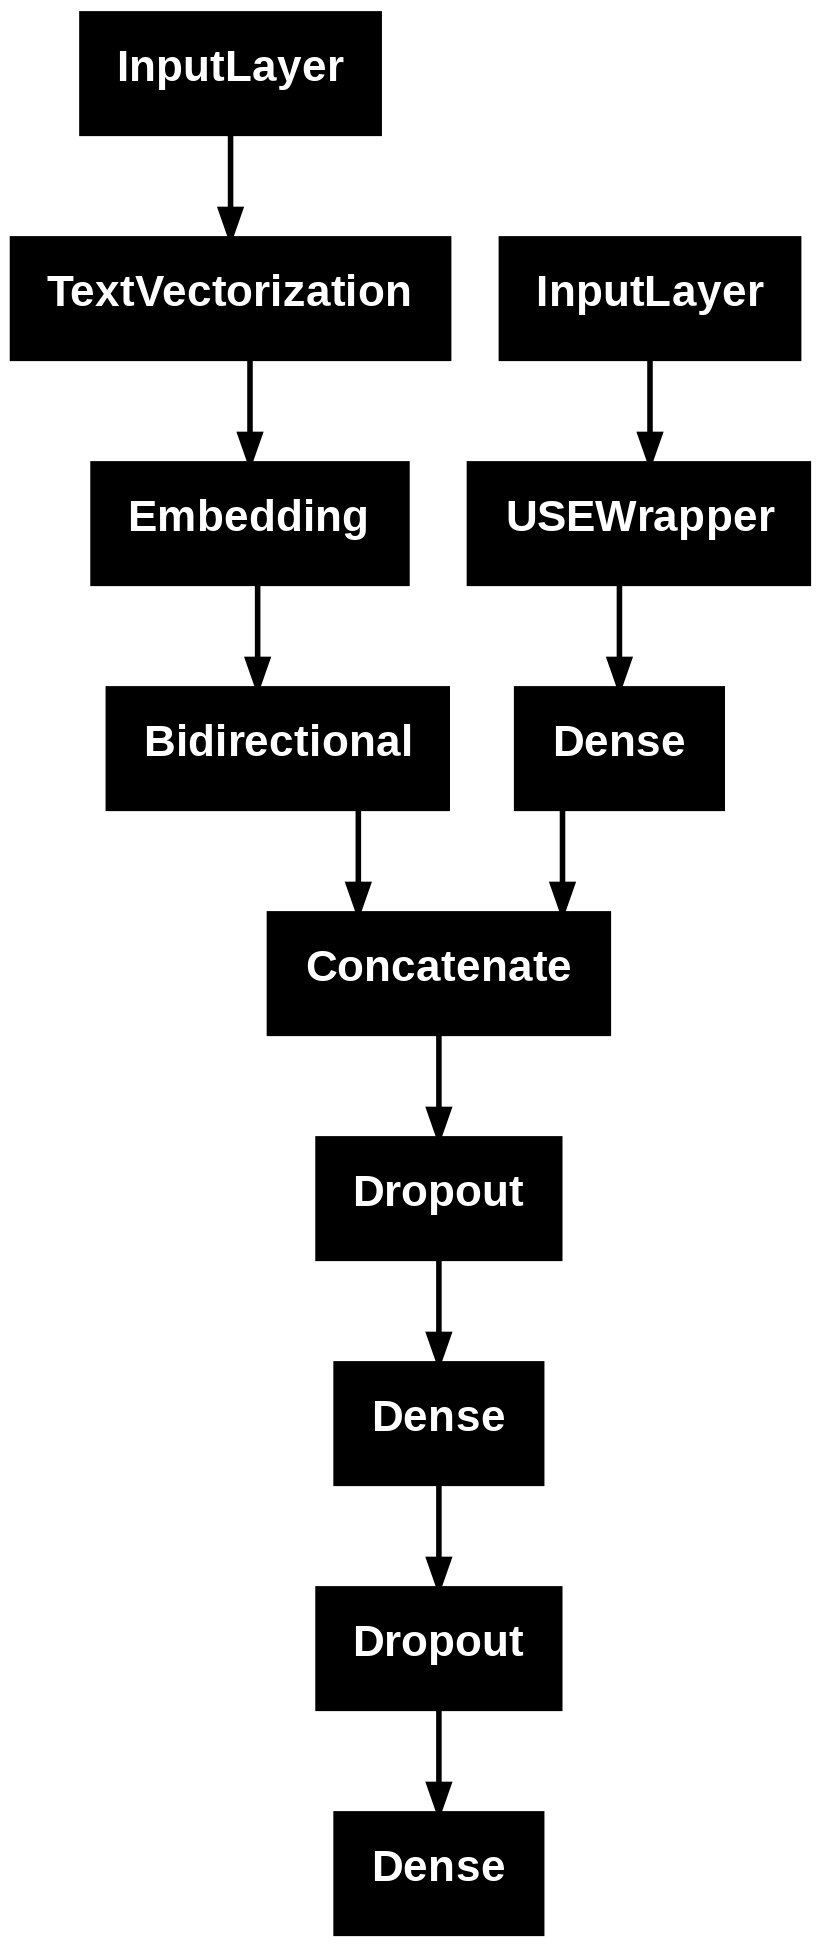

In [80]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [81]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [82]:
# combining token and chars into dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset=tf.data.Dataset.zip(train_char_token_data,train_char_token_labels)

# prefetch and batch dataset
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# lets do same for the validation dataset
validation_char_token_data=tf.data.Dataset.from_tensor_slices((validation_sentences,val_chars))
validation_char_token_labels=tf.data.Dataset.from_tensor_slices(validation_labels_one_hot)
validation_char_token_dataset=tf.data.Dataset.zip(validation_char_token_data,validation_char_token_labels)
validation_char_token_dataset=validation_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset, validation_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [83]:
# # fitting model
# model_4_history=model_4.fit(train_char_token_dataset,
#                             steps_per_epoch=int(0.1*len(train_char_token_dataset)),
#                             epochs=3,
#                             validation_data=validation_char_token_dataset,
#                             validation_steps=int(0.1*len(validation_char_token_dataset)))

In [84]:
# # evaluate on whole dataset
# model_4.evaluate(validation_char_token_dataset)

In [85]:
# # to make prediction, lets pass the tuple of chars and tokens to the predict() funtion
# model_4_pred=model_4.predict(validation_char_token_dataset)
# model_4_pred

In [86]:
# # lets convert the probability in to the class
# model_4_pred_classes=tf.argmax(model_4_pred,axis=1)
# model_4_pred_classes

In [87]:
# # calculate performance metrics
# model_4_results=calculate_results(validation_labels,model_4_pred_classes)
# model_4_results

# Model 5: Transfer Learning with pre-trained token embeddings + character embeddings + positional embeddings

In [88]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

Since our "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.

To do this, we can use the tf.one_hot utility.

In [89]:
train_df.line_number.value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15.

<Axes: ylabel='Frequency'>

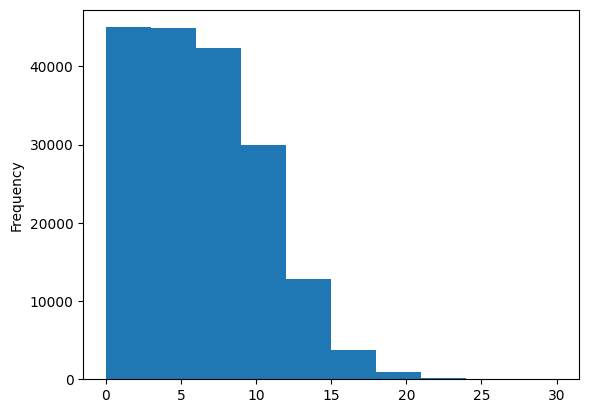

In [90]:
# check the distribution of line_number column
train_df.line_number.plot.hist()

In [91]:
# Use Tensorflow to create one-hot encoded tensors of our "line_number" column
train_line_number_one_hot=tf.one_hot(train_df.line_number.to_numpy(),depth=15)
val_line_number_one_hot=tf.one_hot(val_df.line_number.to_numpy(),depth=15)
test_line_number_one_hot=tf.one_hot(test_df.line_number.to_numpy(),depth=15)

In [92]:
train_line_number_one_hot.shape

TensorShape([180040, 15])

In [93]:
train_line_number_one_hot[:20]

<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [94]:
# now lets do same for the "total lines" columns
train_df.total_lines.value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

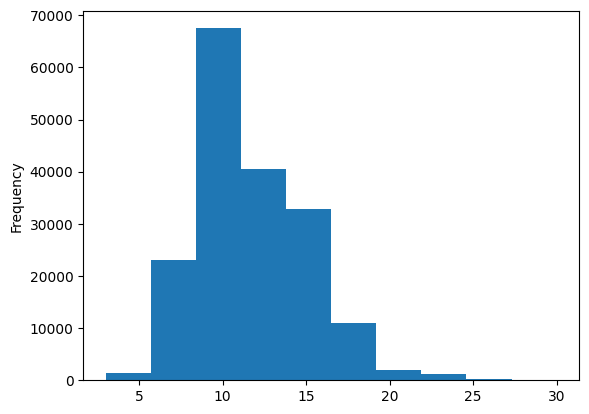

In [95]:
# check the distribution
train_df.total_lines.plot.hist(

)

Looking at the distribution of our "toal lines" column, the value of 20 looks like it covers the majority of samples.
lets confirm it with np.percentile()

In [96]:
np.percentile(train_df.total_lines,98)

np.float64(20.0)

In [97]:
# lets one hot encode out "total line" column
train_total_lines_one_hot=tf.one_hot(train_df.total_lines.to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df.total_lines.to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df.total_lines.to_numpy(),depth=20)

In [98]:
train_total_lines_one_hot.shape,train_total_lines_one_hot[:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

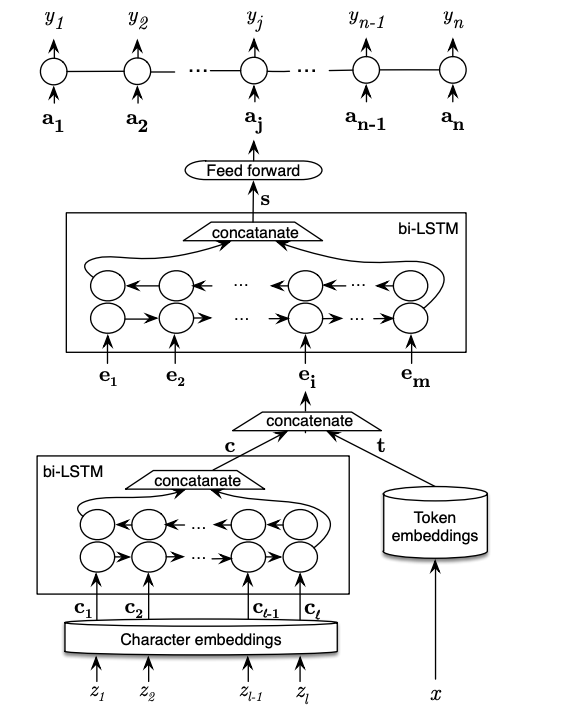

1. Create a token-level model (similar to model_1)

2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)

3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)

4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)

5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [99]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

class USEWrapper(layers.Layer):
    def __init__(self, **kwargs):
        super(USEWrapper, self).__init__(**kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Step 2: Token-level input model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = USEWrapper(name="use_layer")(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

#2. char inputs
char_inputs=layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embed=char_embedding(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(32))(char_embed)
char_model=tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

#3. Line number inputs
line_number_inputs=layers.Input(shape=(15,),dtype=tf.int32,name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs, outputs=x)

#4 total line inputs
total_lines=layers.Input(shape=(20,),dtype=tf.int32,name="total_lines_input")
y=layers.Dense(32,activation="relu")(total_lines)
total_lines_model=tf.keras.Model(inputs=total_lines,outputs=y)

# 5. combine token and char embedding into a hybrid embedding
combined_embedding=layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,char_model.output])
z=layers.Dense(256,activation="relu")(combined_embedding)
z=layers.Dropout(0.5)(z)
#6. combine positional embedding with the combined char and token embedding
z=layers.Concatenate(name="tokan_char_and_positional_embed")([line_number_model.output,total_lines_model.output, z])

#7, create output layer
output_layer=layers.Dense(5,activation="relu",name="output_layer")(z)

#8 put together model
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input
                               ],
                       outputs=output_layer)
model_5.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer           │ (None, 512)       │          0 │ token_input[0][0] │
│ (USEWrapper)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 290, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     65,664 │ use_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     14,848 │ char_embedding[2… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid_… │ (None, 192)       │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     49,408 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tokan_char_and_pos… │ (None, 320)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ tokan_char_and_p… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

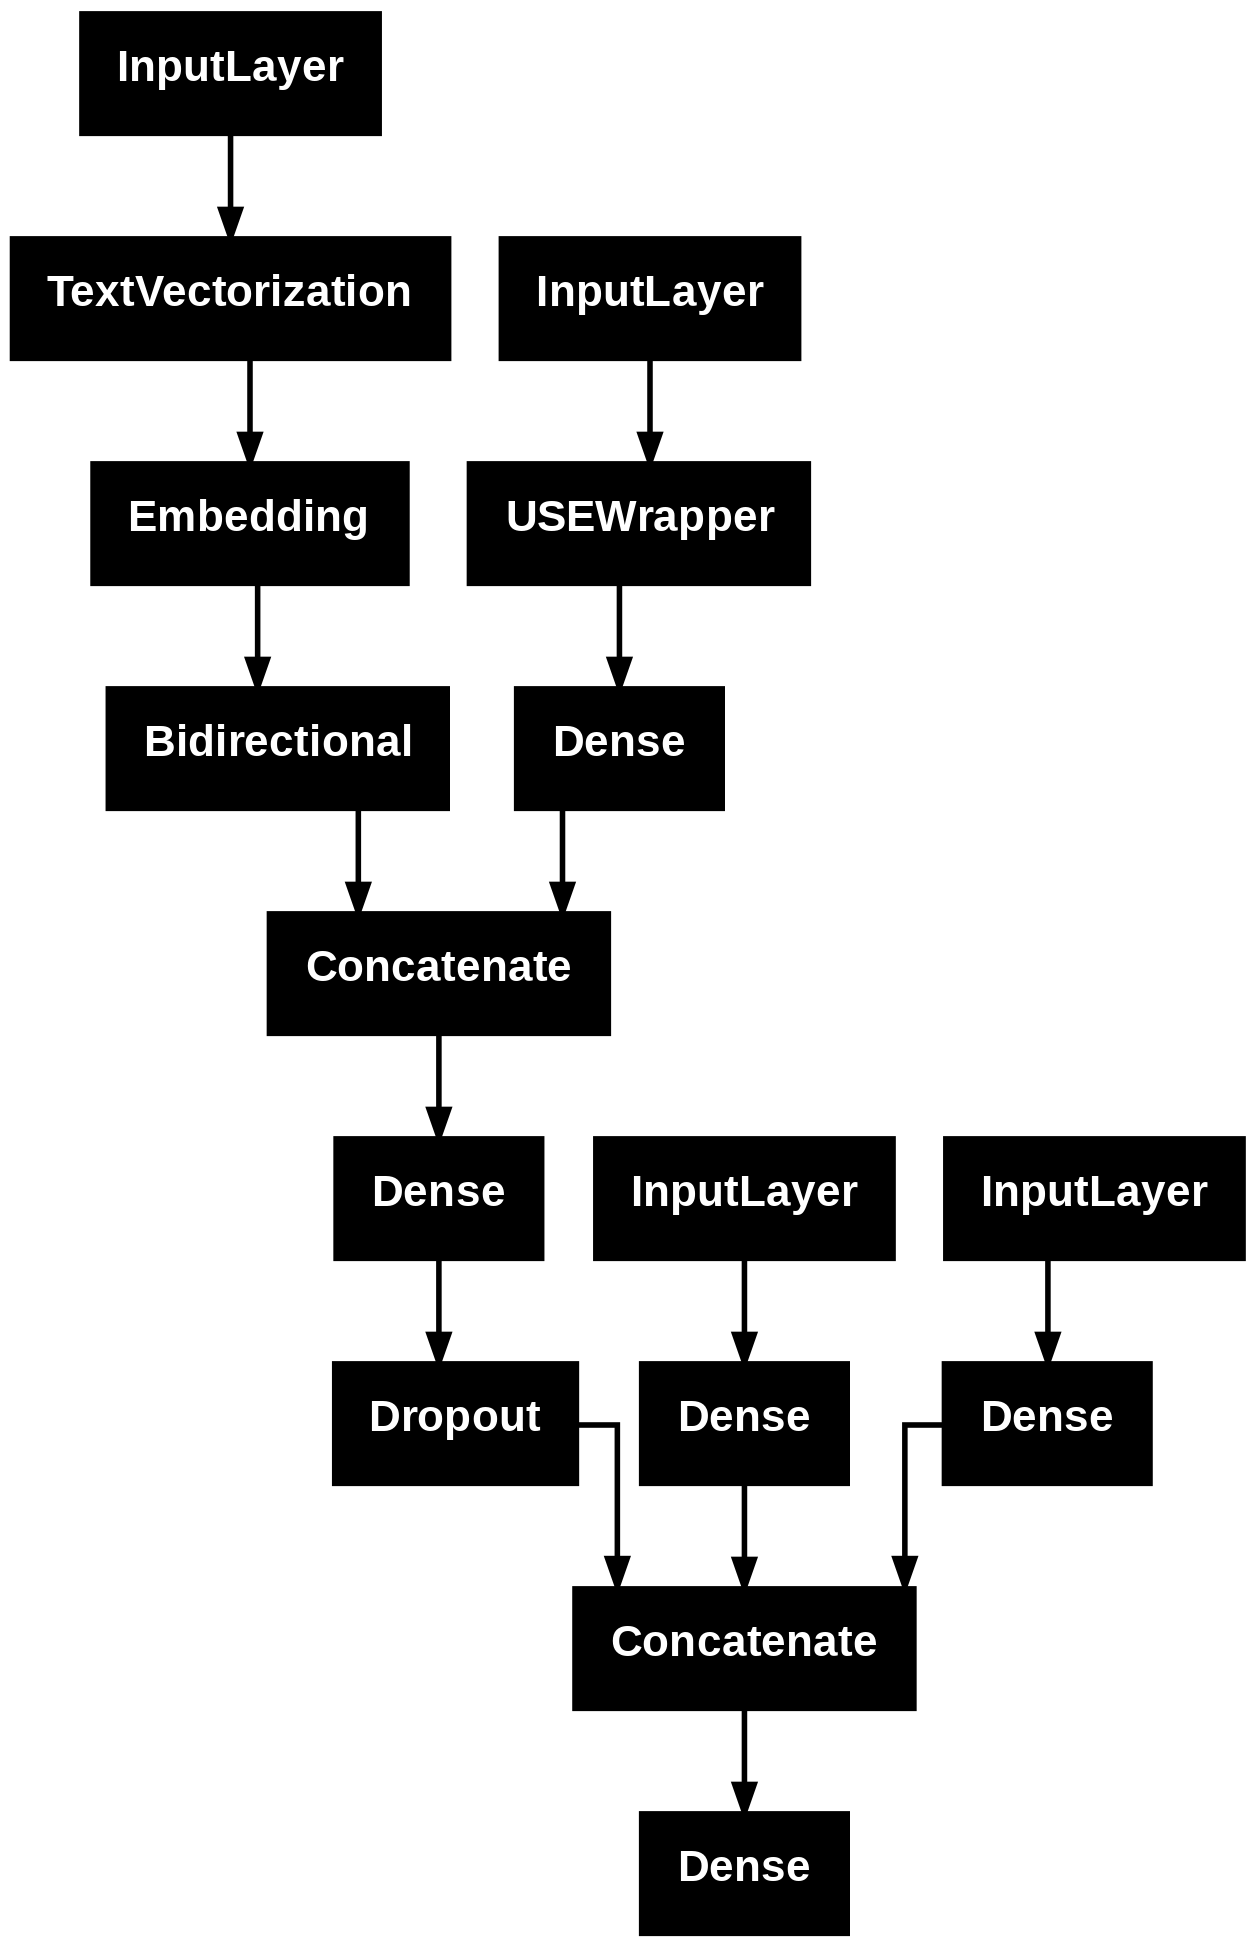

In [100]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)


In [101]:
# Compile
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [102]:
# create a tribrid embedding dataset
# create a training and validation dataset
train_char_token_position_data=tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                     train_total_lines_one_hot,
                                                                     train_chars,
                                                                     train_sentences))
train_char_token_position_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_position_dataset=tf.data.Dataset.zip(train_char_token_position_data,train_char_token_position_labels)
train_char_token_position_dataset=train_char_token_position_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation dataset

val_char_token_position_data=tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                                 val_total_lines_one_hot,
                                                                 val_chars,
                                                                 validation_sentences))
val_char_token_position_labels=tf.data.Dataset.from_tensor_slices(validation_labels_one_hot)
val_char_token_position_dataset=tf.data.Dataset.zip(val_char_token_position_data,val_char_token_position_labels)
val_char_token_position_dataset=val_char_token_position_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_position_dataset, val_char_token_position_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [108]:
model_5_history=model_5.fit(train_char_token_position_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_char_token_position_dataset)),
                            validation_data=val_char_token_position_dataset,
                            validation_steps=int(0.1*len(val_char_token_position_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 152s 271ms/step - accuracy: 0.6878 - loss: 1.1048 - val_accuracy: 0.7104 - val_loss: 1.0749
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 135s 241ms/step - accuracy: 0.7021 - loss: 1.0913 - val_accuracy: 0.7178 - val_loss: 1.0763
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 134s 239ms/step - accuracy: 0.6927 - loss: 1.1062 - val_accuracy: 0.7164 - val_loss: 1.0944


In [109]:
model_5_pred=model_5.predict(val_char_token_position_dataset)
model_5_pred

945/945 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step


array([[1.2680327 , 0.21142101, 0.12245645, 1.2323706 , 0.13467413],
       [1.2489153 , 0.20872489, 0.9751613 , 0.8943976 , 0.6818451 ],
       [0.7067992 , 0.19303396, 1.5393231 , 0.51285887, 0.18482263],
       ...,
       [0.20069443, 0.61119324, 0.16284005, 0.10178209, 0.44060373],
       [0.13910866, 0.736888  , 0.169529  , 0.05068796, 0.2206911 ],
       [0.18407656, 0.91453207, 0.22548495, 0.06216297, 0.21985509]],
      dtype=float32)

In [110]:
model_5_class=tf.argmax(model_5_pred,axis=1)
model_5_class

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 2, ..., 1, 1, 1])>

In [111]:
# get the results
model_5_results=calculate_results(validation_labels,
                                  model_5_class)
model_5_results

{'accuracy': 71.56427909439958,
 'precision': 0.711696284543572,
 'recall': 0.7156427909439957,
 'f1': 0.708953241451337}

In [106]:
#Compare models